In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.pinopi as pnp
import standard_sequences.sweeppiamp as sweeppiamp
import joblib
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit
from skopt import gp_minimize
from skopt.space import Categorical
from skopt.callbacks import CheckpointSaver
import classifiers.classifier as classifier
from scipy.optimize import minimize as scipy_minimize

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)

Qubit(ef_time=44, IQ_angle=60, RO_LO=6.6247, qubit_id=q1, ef_ssm=-0.25684, ef_half_amp=1.3, ro_amp=0.25, RO_LO_pwr=16, ef_half_time=25, ge_time=77, qubit_thr=[-10000, -600], ge_ssm=-0.1144, mixer_offset_ge=2.5, ROIF=0.10268999999999995, ef_amp=1.5, ro_dur=5000, RO_IF=None, ge_amp=1.01, mixer_offset_ef=6, ro_freq=6.72739)
Qubit(ef_time=None, IQ_angle=25, RO_LO=6.6247, qubit_id=q2, ef_ssm=-0.2962, ef_half_amp=None, ro_amp=0.45, RO_LO_pwr=16, ef_half_time=None, ge_time=74, qubit_thr=[-10000, 1900], ge_ssm=-0.154, mixer_offset_ge=None, ROIF=0.030840000000000423, ef_amp=1, ro_dur=5000, RO_IF=None, ge_amp=0.4, mixer_offset_ef=None, ro_freq=6.65554)


In [3]:
def correct_probabilities_over_time(M: np.ndarray,
                                    P_measured_mat: np.ndarray
                                   ) -> np.ndarray:
    """
    Perform constrained least-squares inversion on each column of P_measured_mat.
    
    Args:
        M:             (3×3) scale/assignment matrix.
        P_measured_mat:(3×N) measured probability columns.
    
    Returns:
        P_true_mat:   (3×N) corrected, physical probability columns.
    """
    num_levels, num_times = P_measured_mat.shape
    assert M.shape == (num_levels, num_levels), "M must be square of size 3"
    
    # Prepare output
    P_true_mat = np.zeros_like(P_measured_mat)
    
    # Common settings
    bounds = [(0, 1)] * num_levels
    constraint = {'type': 'eq', 'fun': lambda P: np.sum(P) - 1}

    # Loss function factory
    def make_loss(P_meas):
        return lambda P_true: np.linalg.norm(M @ P_true - P_meas)**2

    # Loop over each time index
    for i in range(num_times):
        P_meas = P_measured_mat[:, i]
        loss = make_loss(P_meas)
        x0 = np.ones(num_levels) / num_levels  # uniform initial guess
        
        res = scipy_minimize(loss,
                       x0,
                       bounds=bounds,
                       constraints=[constraint])
        
        if not res.success:
            raise RuntimeError(f"Optimization failed at column {i}: {res.message}")
        
        P_true_mat[:, i] = res.x
    
    return P_true_mat

In [4]:
def pi_ge_tune(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    reps: int,
    amp: float,
    pi_ge_time: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    # sweeppiamp.pi_ge_amp(
    #     q1, q2, general_vals_dict, num_steps, amp, pi_ge, swap_freq, swap_time
    # )
    sweeppiamp.pi_ge_gaussian_tune_iq(
        q1,
        q2,
        general_vals_dict,
        num_steps=3,
        amp=0.8,
        pi_ge_time=24,
        swap_freq=-0.21,
        swap_time=213.58765318403013,
        file_length=16000,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

# Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    I1 = np.mean(I1_raw)
    Q1 = np.mean(Q1_raw)
    I2 = np.mean(I2_raw)
    Q2 = np.mean(Q2_raw)

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
     # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        }
    )

    df_pop = pd.DataFrame(
        {
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        })

    scale_matrix= joblib.load("classifiers/scale_matrix.pkl")
    P_matrix=np.array([df_prob["P_g"], df_prob["P_e"], df_prob["P_f"]])
    P_matrix_scaled =correct_probabilities_over_time(scale_matrix, P_matrix)
    df_prob_scaled = pd.DataFrame(
        {
            "P_f": P_matrix_scaled[2],
            "P_e": P_matrix_scaled[1],
            "P_g": P_matrix_scaled[0],
        },
    )
    return I1, Q1, I2, Q2, df_prob_scaled

In [5]:
def get_ground_IQ(    
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    reps: int):

    pnp.pi_nopi_swap(
    q1,
    q2,
    general_vals_dict,
    copief=0,
    coswap=1,
    copige=0,
    num_steps=3,
    swap_freq=0,
    swap_time=0,
    phase=0,
    swap_amp=0
)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    I1 = np.mean(I1_raw)
    Q1 = np.mean(Q1_raw)
    I2 = np.mean(I2_raw)
    Q2 = np.mean(Q2_raw)

    return I1, Q1, I2, Q2

In [6]:
# reps = 15000
# amp_vals = np.round(np.arange(0.75, 1.51, 0.01), 2)
# time_vals = np.round(np.arange(40, 101, 1), 1)
# space = [
#     Categorical(amp_vals.tolist(), name="amp"),
#     Categorical(time_vals.tolist(), name="pi_ge_time"),
# ]


# def minimization_function(params):

#     amp, pi_ge_time = params
#     values, IQ_df, df_prob = pi_ge_tune(
#         q1,
#         q2,
#         general_vals_dict,
#         num_steps=3,
#         reps=reps,
#         amp=amp,
#         pi_ge_time=pi_ge_time,
#     )

#     min_val = np.mean(df_prob["P_f"]) - np.mean(df_prob["P_g"])

#     return min_val


# checkpoint_file = "gp_minimize_checkpoint.pkl"
# n_calls = 35
# checkpoint_saver = CheckpointSaver(checkpoint_file, compress=9)

# # ... define your space and minimization_function as before ...

# checkpoint_result = None
# if os.path.exists(checkpoint_file):
#     try:
#         with open(checkpoint_file, "rb") as f:
#             checkpoint_result = pickle.load(f)
#         print("Checkpoint loaded successfully.")
#     except Exception as e:
#         print(f"Checkpoint corrupted ({e}), deleting and starting over.")
#         os.remove(checkpoint_file)
#         checkpoint_result = None

# if checkpoint_result is not None:
#     x0 = checkpoint_result.x_iters
#     y0 = checkpoint_result.func_vals
#     already_done = len(x0)
#     remaining = n_calls - already_done
#     print(f"Already completed: {already_done} calls; Remaining: {remaining}")
#     if remaining <= 0:
#         result = checkpoint_result
#     else:
#         result = gp_minimize(
#             func=minimization_function,
#             dimensions=space,
#             acq_func="EI",
#             n_calls=remaining,
#             n_initial_points=0,
#             noise="gaussian",
#             random_state=42,
#             x0=x0,
#             y0=y0,
#             callback=[checkpoint_saver],
#         )
# else:
#     print("No checkpoint found, starting new optimization.")
#     result = gp_minimize(
#         func=minimization_function,
#         dimensions=space,
#         acq_func="EI",
#         n_calls=n_calls,
#         n_initial_points=10,
#         noise="gaussian",
#         random_state=42,
#         callback=[checkpoint_saver],
#     )

# print("Optimization finished!")
# print("Best parameters found:", result.x)
# print("Best score:", result.fun)

In [ ]:
from skopt.space import Categorical
import classifiers.classifier as classifier
from skopt import Optimizer
import json
# Define discrete search space
amp_vals = np.round(np.arange(0.75, 1.51, 0.01), 2)
time_vals = np.round(np.arange(40, 101, 1), 1)
space = [
    Categorical(amp_vals.tolist(), name="amp"),
    Categorical(time_vals.tolist(), name="pi_ge_time"),
]

# Constants
reps = 15000
log_file = "optimizer_trials.jsonl"
state_file = "optimizer_state.pkl"
n_calls = 35

# Ground state IQ reference
I1_g, Q1_g, I2_g, Q2_g = get_ground_IQ(q1, q2, general_vals_dict, num_steps=3, reps=50000)

def to_json_serializable(obj):
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (list, tuple)):
        return [to_json_serializable(x) for x in obj]
    else:
        return obj

def log_trial(params, loss):
    params_py = to_json_serializable(params)
    loss_py = to_json_serializable(loss)
    with open(log_file, "a") as f:
        json.dump({"params": params_py, "loss": loss_py}, f)
        f.write("\n")

# Load past results
def load_trials():
    x0, y0 = [], []
    seen = set()
    if os.path.exists(log_file):
        with open(log_file, "r") as f:
            for line in f:
                entry = json.loads(line)
                key = tuple(entry["params"])
                if key not in seen:
                    seen.add(key)
                    x0.append(list(key))
                    y0.append(entry["loss"])
    return x0, y0

# Define objective
seen_points = set()

def minimize_obj(params):
    key = tuple(params)
    if key in seen_points:
        print(f"Skipping previously evaluated point: {params}")
        return 1e6

    amp, pi_ge_time = params
    try:
        I1, Q1, I2, Q2,df_prob = pi_ge_tune(
            q1, q2, general_vals_dict,
            num_steps=3, reps=reps,
            amp=amp, pi_ge_time=pi_ge_time,
        )
        min1 = np.sqrt((I1 - I1_g) ** 2 + (Q1 - Q1_g) ** 2)
        min2 = np.sqrt((I2 - I2_g) ** 2 + (Q2 - Q2_g) ** 2)
        loss = min1 + min2 + 5e3 * np.mean(df_prob['P_f'])
        print(f'-------------- min1 = {min1}--------------')
        print(f'-------------- min2 = {min2}--------------')
        print(f'-------------- P_f = {np.mean(df_prob['P_f'])}--------------')

        log_trial(params, loss)
        seen_points.add(key)
        return loss

    except Exception as e:
        print(f"Hardware error for {params}: {e}")
        return 1e6

# Resume or start fresh
x0, y0 = load_trials()
print(f"Loaded {len(x0)} previous trials")

opt = Optimizer(dimensions=space, acq_func="EI", random_state=42)

# Warm-start if prior data exists
for x_i, y_i in zip(x0, y0):
    opt.tell(x_i, y_i)

# Run new trials
for _ in range(n_calls - len(x0)):
    x = opt.ask()
    y = minimize_obj(x)
    opt.tell(x, y)

    # Save optimizer state
    with open(state_file, "wb") as f:
        import pickle
        pickle.dump(opt, f)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 50000
Buffers per acquistion: 49
DAQ samples per pattern: 8192
0, No error
Capturing 49 buffers. Press <enter> to abort
Capture completed in 17.138941 sec
Captured 49 buffers (2.858987 buffers per sec)
Captured 150528 records (8782.806578 records per sec)
Transferred 2466250752 bytes (143897502.971849 bytes per sec)
Loaded 0 previous trials
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 

c:\Users\quantum1\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.5, 77] before, using random point [1.26, 47]
  warnings.warn(


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort


In [ ]:
best_index = np.argmin(opt.yi)
print("Best parameters:", opt.Xi[best_index])
print("Best score:", opt.yi[best_index])

Optimal amplitude: 0.72
Optimal pi_ge_time: 30
Minimum total IQ error: -0.5488000000000001


In [ ]:
I1, Q1, I2, Q2 = pi_ge_tune(
    q1,
    q2,
    general_vals_dict,
    num_steps=3,
    reps=reps,
    amp=result.x[0],
    pi_ge_time=result.x[1],
)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 6.225981 sec
Captured 15 buffers (2.409259 buffers per sec)
Captured 46080 records (7401.243561 records per sec)
Transferred 754974720 bytes (121261974.500808 bytes per sec)


ValueError: not enough values to unpack (expected 4, got 3)

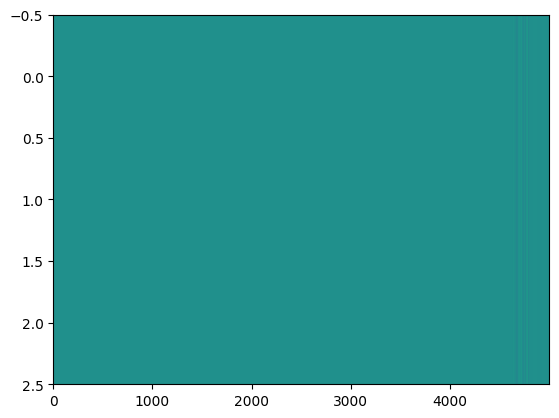

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 10.012033 sec
Captured 15 buffers (1.498197 buffers per sec)
Captured 46080 records (4602.462083 records per sec)
Transferred 754974720 bytes (75406738.774833 bytes per sec)


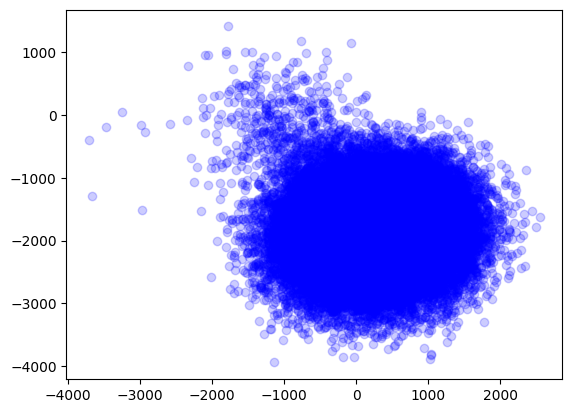

In [ ]:
sweeppiamp.pi_ge_gaussian_tune_iq(
    q1,
    q2,
    general_vals_dict,
    num_steps=3,
    amp=result.x[0],
    pi_ge_time=result.x[1],
    swap_freq=-0.21,
    swap_time=213.58765318403013,
    file_length=16000,
    verbose=False,
)
num_steps = 3
reps = 15000
wx.wx_set_and_amplitude_and_offset(
    amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
)
# Acquire the raw IQ data
values = daq.run_daq_het_2q(
    q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
)
reps = 250000
swap_freq = -0.0194
swap_time = 0.5 * 7 / abs(swap_freq)
phase = 0
swap_amp = 1.36

square_values = pnp.pi_nopi_swap(
    q1,
    q2,
    general_vals_dict,
    copief=0,
    coswap=1,
    copige=0,
    num_steps=3,
    swap_freq=swap_freq,
    swap_time=swap_time,
    phase=phase,
    swap_amp=swap_amp,
)

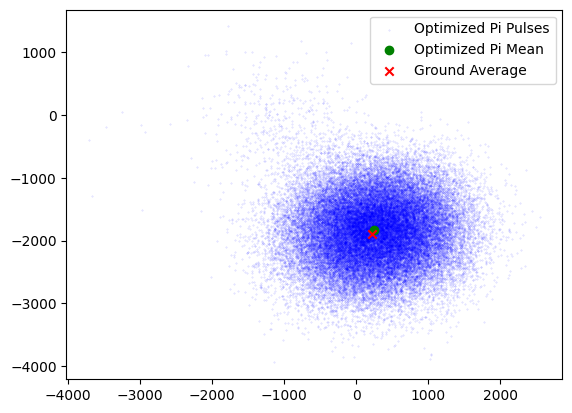

In [ ]:
plt.scatter(
    values.rec_readout_1[0],
    values.rec_readout_1[1],
    label="Optimized Pi Pulses",
    color="blue",
    alpha=0.2,
    s=0.1,
)
plt.scatter(
    square_values.rec_readout_1[0],
    square_values.rec_readout_1[1],
    label="Square Pi Pulses",
    color="orange",
    alpha=0.2,
    s=0.1,
)
plt.scatter(
    np.mean(values.rec_readout_1[0]),
    np.mean(values.rec_readout_1[1]),
    label="Optimized Pi Mean",
    color="green",
)
plt.scatter(
    np.mean(square_values.rec_readout_1[0]),
    np.mean(square_values.rec_readout_1[1]),
    label="Square Pi Mean",
    color="green",
    marker="p",
)
plt.legend()